# Import libraries and dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import seaborn as sns 

from wordcloud import WordCloud
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tqdm import tqdm
#nltk.download('stopwords')

from IPython.display import display, HTML

In [2]:
df = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/bitcoin_tweets.csv", 
                 #nrows=1000
                )

/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_9708/2019011697.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/bitcoin_tweets.csv",


In [3]:
df.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False


In [4]:
for sentence in list(df.text)[:5]:
    print("\n", sentence)


 Blue Ridge Bank shares halted by NYSE after #bitcoin ATM announcement https://t.co/xaaZmaJKiV @MyBlueRidgeBank… https://t.co/sgBxMkP1SI

 😎 Today, that's this #Thursday, we will do a "🎬 Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expe… https://t.co/go6aDgRml5

 Guys evening, I have read this article about BTC and would like to share with you all - https://t.co/QxCZgmuy3B… https://t.co/o6wn7ppkVY

 $BTC A big chance in a billion! Price: \4872644.0 (2021/02/11 08:51) #Bitcoin #FX #BTC #crypto

 This network is secured by 9 508 nodes as of today. Soon, the biggest bears will recognise: #BTC in too big to fail… https://t.co/1XovDA8rKw


# Cleaning of dataset 

### Useful functions

In [5]:
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'#', '', s)
    s = re.sub(r'\n', ' ', s)
    s = re.sub(r'\t', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

def lower_case(text):
    text = text.lower()
    return text

def keep_date_rows(df, columns):
    """
    Keep rows with date format
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df = df.dropna(subset=[col])
    return df 

def keep_numeric_rows(df, columns):
    """
    Keep rows with date format
    """
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=[col])
    return df 

In [6]:
def clean_tweet(df, to_write):
    """
    Clean the dataframe and write it if needed
    """
    # Remove retweeted tweets
    df = df[df.is_retweet==False]
    
    # Keep relevant columns
    relevant_features = ["user_name", "user_created", "user_followers", "user_friends", "user_favourites", "user_verified", "date", "text"]
    df = df[relevant_features]
    
    # Clean text 
    df['clean_tweet'] = df['text'].apply(clean_text)
    
    # Lower Case
    df["clean_tweet"] = df["clean_tweet"].apply(lower_case)
    
    # Remove emoji 
    df["clean_tweet"] = df["clean_tweet"].astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    
    # Keep rows with date format 
    df = keep_date_rows(df, ["user_created", "date"])
    
    # Keep rows with numeric type
    df = keep_numeric_rows(df, ["user_followers", "user_friends", "user_favourites"])
    
    # Drop unrelevant column
    df.drop(columns=["text"], inplace=True)
    
    # Sort by date 
    df = df.sort_values(by="date", ascending=True)
    
    # Rename tweet column
    df.rename(columns={"clean_tweet":"sentence"}, inplace=True)
    df['sentence'] = df['sentence'].astype("string")
    
    # Drop nan tweets
    df = df.dropna(subset=['sentence'])
    
    if to_write:
        print("The dataset is being wr")
        # Write csv 
        df.to_csv('/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/tweets_processed_2.csv', index=False)
    
    return df

In [7]:
df = clean_tweet(df, True)

The dataset is being wr


In [8]:
df.head(5)

,user_name,user_created,user_followers,user_friends,user_favourites,user_verified,date,sentence
21523,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:04,2 debunking 9 bitcoin myths by cryptoc...
21524,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:04,weekend read keen to learn about crypto as...
21522,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:06,4 bloomberg lp cryptooutlook 2021 with cr...
21521,Iconic Holding,2021-01-05 13:22:24,301.0,1075.0,361.0,False,2021-02-05 10:52:07,"5 blockchain 50 2021 by , cryptocurren..."
21520,Nick Doevendans,2020-06-12 16:50:07,37.0,123.0,410.0,False,2021-02-05 10:52:26,reddcoin rdd to the moon altcoin turnreddcoin...


In [9]:
def plot_wordcloud(df):
    text = df["sentence"].to_string()
    wordcloud = WordCloud(relative_scaling=0.5 , background_color='white',stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(9,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.savefig("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/bitcoin-prediction-using-twitter/documents/wordcloud_tweets_to_label")

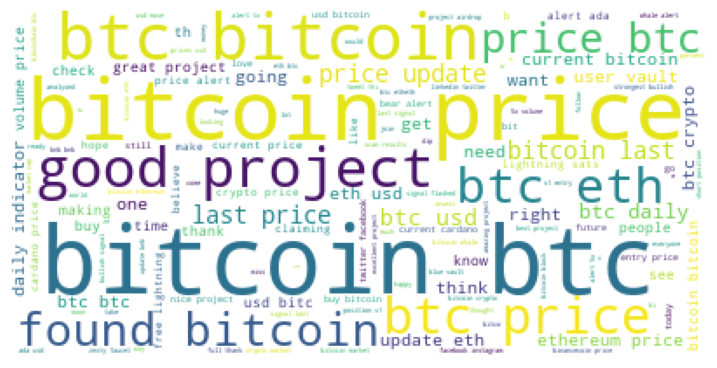

<Figure size 640x480 with 0 Axes>

In [11]:
plot_wordcloud(df)

In [10]:
len(df)

4584416